# Fehlerklassifikation für Condition Monitoring

Dieses Notebook trainiert Modelle zur Klassifikation von Maschinenzuständen:

1. **Random Forest** - Klassisches ML
2. **XGBoost** - Gradient Boosting
3. **1D-CNN** - Deep Learning auf Zeitreihen
4. **MLP (Feedforward)** - Auf extrahierten Features

**Klassen:**
- 0: Normal
- 1: Unwucht (Unbalance)
- 2: Lagerschaden (Bearing Fault)
- 3: Ausrichtungsfehler (Misalignment)

In [1]:
# Installation
# !pip install numpy pandas scikit-learn matplotlib tensorflow xgboost seaborn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

import os
os.makedirs('../models/trained', exist_ok=True)
os.makedirs('../data/simulated', exist_ok=True)

print("Setup abgeschlossen!")

Setup abgeschlossen!


## 1. Daten laden

In [3]:
DATA_DIR = '../data/simulated'

try:
    df = pd.read_csv(f'{DATA_DIR}/classification_dataset.csv')
    print(f"Klassifikationsdatensatz geladen: {len(df)} Samples")
except FileNotFoundError:
    print("Datensatz nicht gefunden! Generiere Beispieldaten...")
    
    # Einfache Klassifikationsdaten generieren
    np.random.seed(42)
    n_per_class = 300
    
    class_data = []
    
    for label, (mean_shift, var_mult) in enumerate([
        (0, 1),      # Normal
        (0.5, 1.2),  # Unwucht
        (1.0, 1.5),  # Lagerschaden
        (0.3, 1.3)   # Ausrichtungsfehler
    ]):
        for _ in range(n_per_class):
            features = {
                'rms': 0.5 + mean_shift + np.random.normal(0, 0.1 * var_mult),
                'peak': 1.0 + mean_shift * 1.5 + np.random.normal(0, 0.15 * var_mult),
                'crest_factor': 2.0 + mean_shift * 0.5 + np.random.normal(0, 0.1 * var_mult),
                'kurtosis': 3.0 + mean_shift * 2 + np.random.normal(0, 0.3 * var_mult),
                'skewness': 0.0 + mean_shift * 0.3 + np.random.normal(0, 0.1 * var_mult),
                'std': 0.3 + mean_shift * 0.2 + np.random.normal(0, 0.05 * var_mult),
                'spectral_centroid': 100 + mean_shift * 50 + np.random.normal(0, 10 * var_mult),
                'spectral_spread': 50 + mean_shift * 20 + np.random.normal(0, 5 * var_mult),
                'band_0_100': 0.3 + (0.2 if label == 1 else 0) + np.random.normal(0, 0.02),
                'band_100_200': 0.2 + (0.3 if label == 3 else 0) + np.random.normal(0, 0.02),
                'label': label
            }
            class_data.append(features)
    
    df = pd.DataFrame(class_data)
    df['label_name'] = df['label'].map({
        0: 'normal', 1: 'unbalance', 2: 'bearing', 3: 'misalignment'
    })
    df.to_csv(f'{DATA_DIR}/classification_dataset.csv', index=False)
    print(f"Datensatz generiert: {len(df)} Samples")

print(f"\nKlassenverteilung:")
print(df['label_name'].value_counts() if 'label_name' in df.columns else df['label'].value_counts())

Klassifikationsdatensatz geladen: 1200 Samples

Klassenverteilung:
label_name
normal          300
unbalance       300
bearing         300
misalignment    300
Name: count, dtype: int64


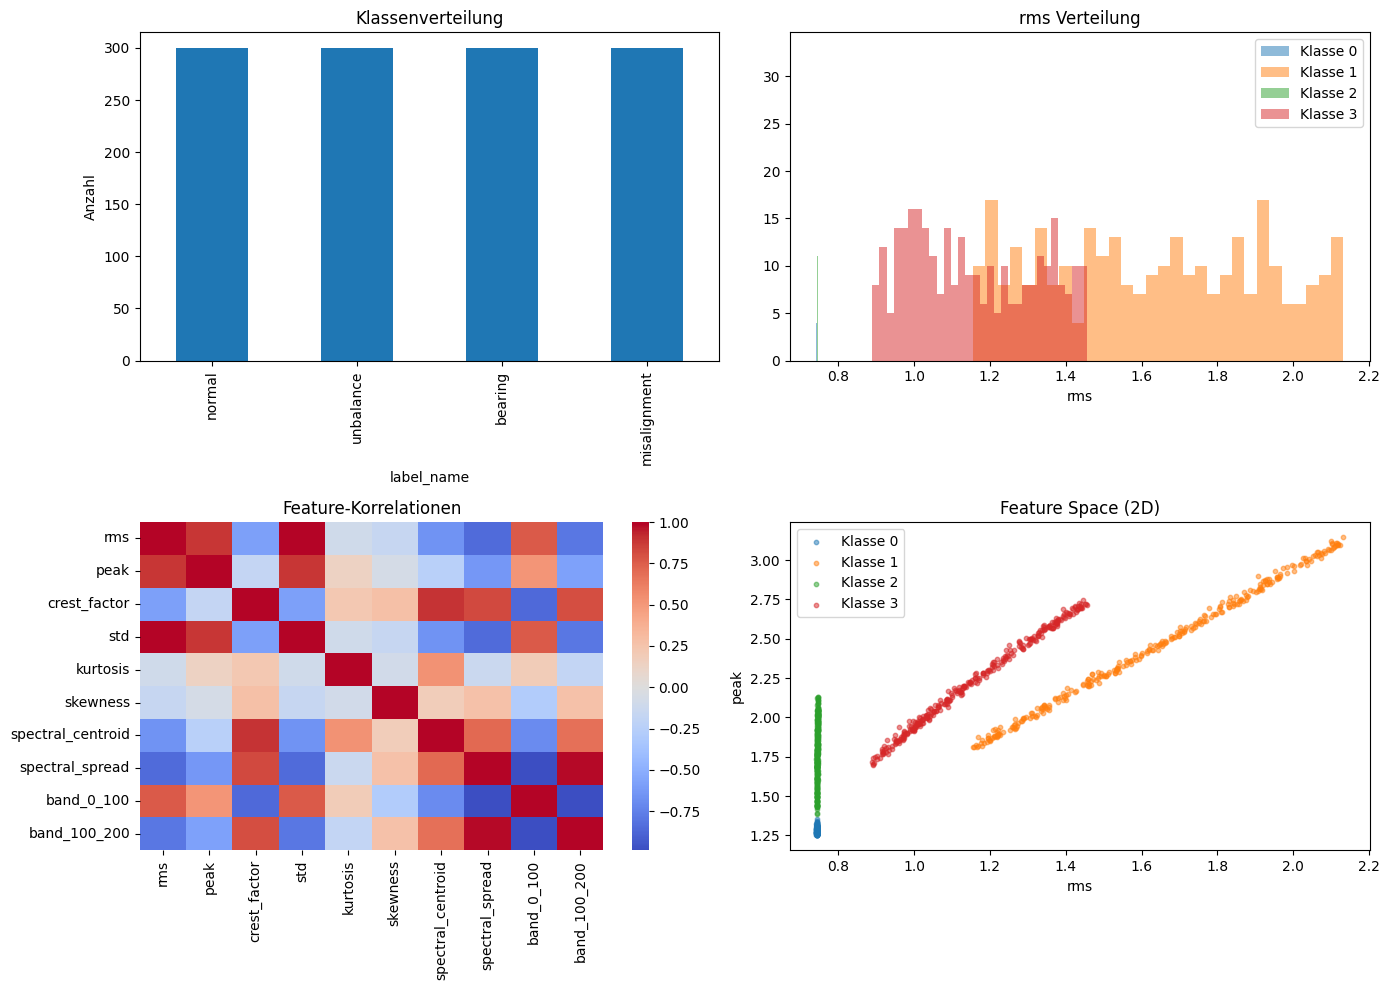

In [4]:
# Daten visualisieren
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Klassenverteilung
if 'label_name' in df.columns:
    df['label_name'].value_counts().plot(kind='bar', ax=axes[0, 0])
else:
    df['label'].value_counts().plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Klassenverteilung')
axes[0, 0].set_ylabel('Anzahl')

# Feature-Verteilungen nach Klasse
feature_cols = [col for col in df.columns if col not in ['label', 'label_name']]

for i, feat in enumerate(['rms', 'crest_factor', 'kurtosis']):
    if feat in df.columns:
        for label in df['label'].unique():
            subset = df[df['label'] == label][feat]
            axes[0, 1].hist(subset, bins=30, alpha=0.5, label=f'Klasse {label}')
        axes[0, 1].set_xlabel(feat)
        axes[0, 1].set_title(f'{feat} Verteilung')
        axes[0, 1].legend()
        break

# Korrelationsmatrix
numeric_cols = df.select_dtypes(include=[np.number]).columns[:10]
corr = df[numeric_cols].corr()
sns.heatmap(corr, ax=axes[1, 0], cmap='coolwarm', center=0, annot=False)
axes[1, 0].set_title('Feature-Korrelationen')

# 2D Scatter (erste 2 Features)
if len(feature_cols) >= 2:
    for label in df['label'].unique():
        subset = df[df['label'] == label]
        axes[1, 1].scatter(subset[feature_cols[0]], subset[feature_cols[1]], 
                          alpha=0.5, label=f'Klasse {label}', s=10)
    axes[1, 1].set_xlabel(feature_cols[0])
    axes[1, 1].set_ylabel(feature_cols[1])
    axes[1, 1].set_title('Feature Space (2D)')
    axes[1, 1].legend()

plt.tight_layout()
plt.savefig('../models/trained/classification_data_overview.png', dpi=150)
plt.show()

## 2. Daten vorbereiten

In [5]:
# Features und Labels
feature_cols = [col for col in df.columns if col not in ['label', 'label_name']]
print(f"Features ({len(feature_cols)}): {feature_cols}")

X = df[feature_cols].values
y = df['label'].values

# Klassennamen
class_names = ['normal', 'unbalance', 'bearing', 'misalignment']

print(f"\nX shape: {X.shape}")
print(f"Klassen: {np.unique(y)}")

Features (13): ['rms', 'peak', 'crest_factor', 'std', 'kurtosis', 'skewness', 'spectral_centroid', 'spectral_spread', 'band_0_100', 'band_100_200', 'band_200_500', 'band_500_1000', 'band_1000_3000']

X shape: (1200, 13)
Klassen: [0 1 2 3]


In [6]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Skalierung
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training: {len(X_train)} Samples")
print(f"Test: {len(X_test)} Samples")

Training: 960 Samples
Test: 240 Samples


## 3. Random Forest

In [7]:
print("Training Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

# Prediction
y_pred_rf = rf_model.predict(X_test_scaled)

print("\n=== Random Forest ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, target_names=class_names))

Training Random Forest...



=== Random Forest ===
Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00        60
   unbalance       1.00      1.00      1.00        60
     bearing       1.00      1.00      1.00        60
misalignment       1.00      1.00      1.00        60

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



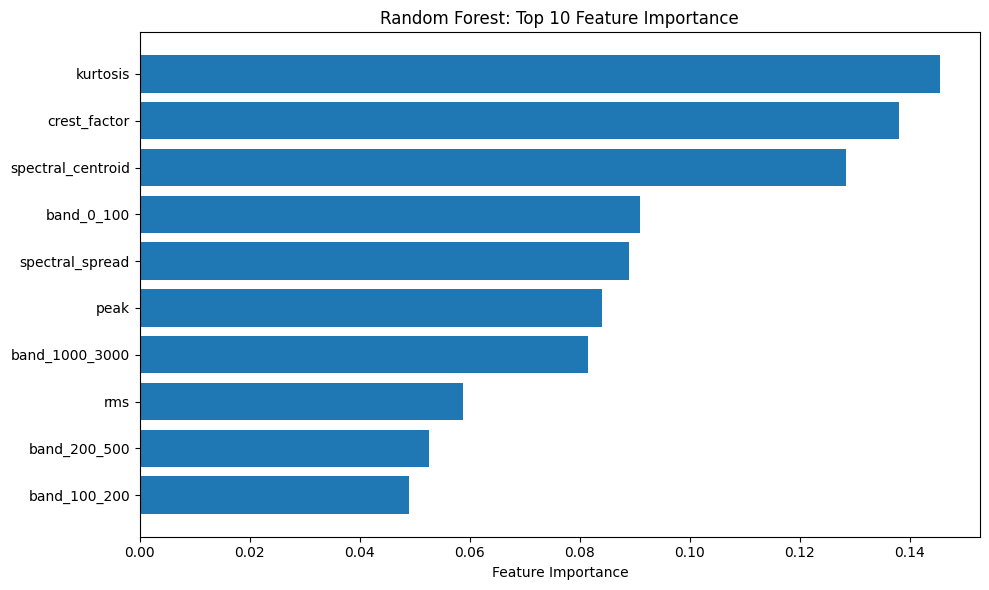

In [8]:
# Feature Importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance['feature'][:10], importance['importance'][:10])
plt.xlabel('Feature Importance')
plt.title('Random Forest: Top 10 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../models/trained/rf_feature_importance.png', dpi=150)
plt.show()

## 4. XGBoost

In [9]:
try:
    from xgboost import XGBClassifier
    
    print("Training XGBoost...")
    
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    )
    
    xgb_model.fit(X_train_scaled, y_train)
    
    y_pred_xgb = xgb_model.predict(X_test_scaled)
    
    print("\n=== XGBoost ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
    print(classification_report(y_test, y_pred_xgb, target_names=class_names))
    
except ImportError:
    print("XGBoost nicht installiert. Überspringe...")
    xgb_model = None
    y_pred_xgb = None

Training XGBoost...



=== XGBoost ===
Accuracy: 0.9958
              precision    recall  f1-score   support

      normal       1.00      0.98      0.99        60
   unbalance       0.98      1.00      0.99        60
     bearing       1.00      1.00      1.00        60
misalignment       1.00      1.00      1.00        60

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



## 5. Deep Learning: MLP

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(f"TensorFlow Version: {tf.__version__}")

2026-01-18 16:58:41.096406: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-18 16:58:41.101530: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-18 16:58:41.108158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768751921.125032   73387 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768751921.131708   73387 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768751921.152850   73387 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

TensorFlow Version: 2.19.0


In [11]:
def create_mlp_model(input_dim, n_classes):
    """
    Multi-Layer Perceptron für Klassifikation.
    """
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(16, activation='relu'),
        layers.Dense(n_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

n_features = X_train_scaled.shape[1]
n_classes = len(np.unique(y))

mlp_model = create_mlp_model(n_features, n_classes)
mlp_model.summary()

2026-01-18 16:58:44.563073: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,956 (15.45 KB)

 Trainable params: 3,764 (14.70 KB)

 Non-trainable params: 192 (768.00 B)

In [12]:
# Training
print("Training MLP...")

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history_mlp = mlp_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=1
)

Training MLP...
Epoch 1/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.1250 - loss: 1.7358

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5521 - loss: 1.0891 - val_accuracy: 0.9375 - val_loss: 1.0730


Epoch 2/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8438 - loss: 0.5510

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9109 - loss: 0.4537 - val_accuracy: 1.0000 - val_loss: 0.7981


Epoch 3/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9688 - loss: 0.2792

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9664 - loss: 0.2524 - val_accuracy: 1.0000 - val_loss: 0.5620


Epoch 4/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9688 - loss: 0.2125

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9734 - loss: 0.1596 - val_accuracy: 1.0000 - val_loss: 0.3810


Epoch 5/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.1020

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9785 - loss: 0.1246 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9850 - loss: 0.1035 - val_accuracy: 1.0000 - val_loss: 0.2363


Epoch 6/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0736

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0820 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9884 - loss: 0.0815 - val_accuracy: 1.0000 - val_loss: 0.1506


Epoch 7/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 0.0262

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9838 - loss: 0.0687 - val_accuracy: 1.0000 - val_loss: 0.0934


Epoch 8/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0872

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9896 - loss: 0.0636 - val_accuracy: 1.0000 - val_loss: 0.0547


Epoch 9/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0226

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9942 - loss: 0.0390 - val_accuracy: 1.0000 - val_loss: 0.0318


Epoch 10/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0199

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9919 - loss: 0.0419 - val_accuracy: 1.0000 - val_loss: 0.0201


Epoch 11/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0108

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0245 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9954 - loss: 0.0315 - val_accuracy: 1.0000 - val_loss: 0.0127


Epoch 12/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9375 - loss: 0.1563

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9907 - loss: 0.0365 - val_accuracy: 1.0000 - val_loss: 0.0077


Epoch 13/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0160

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0212 - val_accuracy: 1.0000 - val_loss: 0.0051


Epoch 14/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0065

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0169 - val_accuracy: 1.0000 - val_loss: 0.0033


Epoch 15/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0106

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9977 - loss: 0.0184 - val_accuracy: 1.0000 - val_loss: 0.0022


Epoch 16/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0142

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9954 - loss: 0.0238 - val_accuracy: 1.0000 - val_loss: 0.0016


Epoch 17/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0138

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9977 - loss: 0.0132 - val_accuracy: 1.0000 - val_loss: 0.0013


Epoch 18/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.0086

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9942 - loss: 0.0190 - val_accuracy: 1.0000 - val_loss: 9.4123e-04


Epoch 19/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9375 - loss: 0.1346

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9954 - loss: 0.0199 - val_accuracy: 1.0000 - val_loss: 7.3649e-04


Epoch 20/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0042

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0102 - val_accuracy: 1.0000 - val_loss: 5.7649e-04


Epoch 21/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0110

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0091 - val_accuracy: 1.0000 - val_loss: 4.7717e-04


Epoch 22/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0074

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0110 - val_accuracy: 1.0000 - val_loss: 3.7431e-04


Epoch 23/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9688 - loss: 0.1301

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0117 - val_accuracy: 1.0000 - val_loss: 3.5115e-04


Epoch 24/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0030

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0089 - val_accuracy: 1.0000 - val_loss: 2.6780e-04


Epoch 25/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0014

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 1.0000 - val_loss: 2.2961e-04


Epoch 26/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0015

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 2.0433e-04


Epoch 27/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0098

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0063 - val_accuracy: 1.0000 - val_loss: 1.7641e-04


Epoch 28/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0025

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0058 - val_accuracy: 1.0000 - val_loss: 1.5499e-04


Epoch 29/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0025

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9954 - loss: 0.0178 - val_accuracy: 1.0000 - val_loss: 1.4732e-04


Epoch 30/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9688 - loss: 0.0785

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0139 - val_accuracy: 1.0000 - val_loss: 1.5330e-04


Epoch 31/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0061

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 1.3846e-04


Epoch 32/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0029

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0030 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 1.2124e-04


Epoch 33/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0017

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0037 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 9.7591e-05


Epoch 34/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 1.0000 - loss: 5.0133e-04

22/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0095     

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9977 - loss: 0.0105 - val_accuracy: 1.0000 - val_loss: 9.8226e-05


Epoch 35/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0060

19/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9994 - loss: 0.0057 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9977 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 8.6659e-05


Epoch 36/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9688 - loss: 0.0499

15/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9931 - loss: 0.0128 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9977 - loss: 0.0065 - val_accuracy: 1.0000 - val_loss: 8.9736e-05


Epoch 37/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 1.0000 - loss: 0.0031

23/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0027  

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 6.5272e-05


Epoch 38/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0018

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0034 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9965 - loss: 0.0090 - val_accuracy: 1.0000 - val_loss: 5.4075e-05


Epoch 39/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0018

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9977 - loss: 0.0059 - val_accuracy: 1.0000 - val_loss: 5.6532e-05


Epoch 40/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0059

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0115 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9977 - loss: 0.0066 - val_accuracy: 1.0000 - val_loss: 4.5505e-05


Epoch 41/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0012

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0031 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 4.5423e-05


Epoch 42/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.5360e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0056 - val_accuracy: 1.0000 - val_loss: 4.2054e-05


Epoch 43/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 7.4701e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9965 - loss: 0.0099 - val_accuracy: 1.0000 - val_loss: 4.0587e-05


Epoch 44/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0068

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 3.7637e-05


Epoch 45/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0012

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0048 - val_accuracy: 1.0000 - val_loss: 3.7187e-05


Epoch 46/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0184

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0062 - val_accuracy: 1.0000 - val_loss: 3.1839e-05


Epoch 47/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0010

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 3.1048e-05


Epoch 48/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 8.5083e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 3.0257e-05


Epoch 49/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0042

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 2.9711e-05


Epoch 50/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0080

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0034 - val_accuracy: 1.0000 - val_loss: 2.4627e-05


Epoch 51/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 1.0000 - loss: 0.0043

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 2.0640e-05


Epoch 52/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.8906e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9954 - loss: 0.0080 - val_accuracy: 1.0000 - val_loss: 2.9591e-05


Epoch 53/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 6.0653e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0086 - val_accuracy: 1.0000 - val_loss: 2.1270e-05


Epoch 54/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.7908e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 2.1034e-05


Epoch 55/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0013

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 1.9087e-05


Epoch 56/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9688 - loss: 0.1131

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0173 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 1.9986e-05


Epoch 57/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 2.2030e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 1.8244e-05


Epoch 58/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0017

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 1.6880e-05


Epoch 59/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0018

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0030 - val_accuracy: 1.0000 - val_loss: 1.6228e-05


Epoch 60/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.7767e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 1.0000 - val_loss: 1.4192e-05


Epoch 61/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 7.4028e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 1.2999e-05


Epoch 62/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0030

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 1.1047e-05


Epoch 63/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.7328e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.9847e-04 - val_accuracy: 1.0000 - val_loss: 1.0387e-05


Epoch 64/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0023

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0029 - val_accuracy: 1.0000 - val_loss: 9.7154e-06


Epoch 65/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 2.2536e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 8.4427e-06


Epoch 66/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 6.1312e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 7.8529e-06


Epoch 67/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.0883e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 7.3698e-06


Epoch 68/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.5528e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 7.2742e-06


Epoch 69/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0016

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 6.9526e-06


Epoch 70/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0054

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 6.7514e-06


Epoch 71/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 4.1953e-04

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0020     

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9977 - loss: 0.0167 - val_accuracy: 1.0000 - val_loss: 8.0168e-06


Epoch 72/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 3.1895e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9954 - loss: 0.0115 - val_accuracy: 1.0000 - val_loss: 1.3387e-05


Epoch 73/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 6.6856e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 1.9990e-05


Epoch 74/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 5.0160e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 1.0544e-05


Epoch 75/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0016

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 8.3172e-06


Epoch 76/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 8.1677e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 7.3648e-06


Epoch 77/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.7364e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 5.6872e-06


Epoch 78/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 5.2694e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 4.9794e-06


Epoch 79/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0015

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 4.5436e-06


Epoch 80/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.5808e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 4.2083e-06


Epoch 81/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 9.5156e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 4.0208e-06


Epoch 82/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 4.8896e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.4193e-04 - val_accuracy: 1.0000 - val_loss: 4.1065e-06


Epoch 83/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 4.9178e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 4.0909e-04 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.5201e-04 - val_accuracy: 1.0000 - val_loss: 3.9985e-06


Epoch 84/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 5.9587e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.7458e-04 - val_accuracy: 1.0000 - val_loss: 3.9165e-06


Epoch 85/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0011

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 3.7153e-06


Epoch 86/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 2.2442e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 7.2495e-04 - val_accuracy: 1.0000 - val_loss: 3.6148e-06


Epoch 87/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.3728e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 3.7526e-06


Epoch 88/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.4362e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.5835e-04 - val_accuracy: 1.0000 - val_loss: 3.4931e-06


Epoch 89/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 9.5002e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0083 - val_accuracy: 1.0000 - val_loss: 4.6044e-06


Epoch 90/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.3106e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9988 - loss: 0.0024 - val_accuracy: 1.0000 - val_loss: 4.6578e-06


Epoch 91/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 4.0080e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 5.5201e-04 - val_accuracy: 1.0000 - val_loss: 3.3676e-06


Epoch 92/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 0.0040

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.4919e-04 - val_accuracy: 1.0000 - val_loss: 3.1131e-06


Epoch 93/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 1.1480e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 2.9231e-06


Epoch 94/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 4.0763e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.6374e-04 - val_accuracy: 1.0000 - val_loss: 2.7344e-06


Epoch 95/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.0787e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0074 - val_accuracy: 1.0000 - val_loss: 2.7952e-06


Epoch 96/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 9.5343e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9977 - loss: 0.0041 - val_accuracy: 1.0000 - val_loss: 3.0137e-06


Epoch 97/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 9.9439e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 3.6731e-06


Epoch 98/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 4.3842e-05

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9988 - loss: 0.0139 - val_accuracy: 1.0000 - val_loss: 5.4513e-06


Epoch 99/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 6.2471e-04

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 9.0831e-04 - val_accuracy: 1.0000 - val_loss: 6.2969e-06


Epoch 100/100


 1/27 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0029

25/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0015 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 3.8706e-06


In [13]:
# MLP Evaluation
y_pred_mlp = np.argmax(mlp_model.predict(X_test_scaled, verbose=0), axis=1)

print("\n=== MLP ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")
print(classification_report(y_test, y_pred_mlp, target_names=class_names))


=== MLP ===
Accuracy: 1.0000
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00        60
   unbalance       1.00      1.00      1.00        60
     bearing       1.00      1.00      1.00        60
misalignment       1.00      1.00      1.00        60

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



## 6. Deep Learning: 1D-CNN auf Rohdaten

In [14]:
# Rohe Zeitreihen laden (falls vorhanden)
try:
    X_raw = np.load(f'{DATA_DIR}/timeseries_X.npy')
    y_raw = np.load(f'{DATA_DIR}/timeseries_y.npy')
    print(f"Rohe Zeitreihen geladen: {X_raw.shape}")
    HAS_RAW_DATA = True
except FileNotFoundError:
    print("Keine rohen Zeitreihen gefunden. Generiere Beispieldaten...")
    
    # Simulierte Zeitreihen
    n_samples = 400
    seq_length = 5000  # 0.5s bei 10kHz
    
    X_raw = np.zeros((n_samples, seq_length))
    y_raw = np.zeros(n_samples, dtype=int)
    
    for i in range(n_samples):
        label = i % 4
        t = np.arange(seq_length) / 10000  # 10kHz
        
        # Grundsignal
        signal = np.sin(2 * np.pi * 25 * t)  # 25 Hz Grundfrequenz
        
        if label == 1:  # Unwucht - erhöhte 1x
            signal += 0.8 * np.sin(2 * np.pi * 25 * t)
        elif label == 2:  # Lagerschaden - Impulse
            impulse_freq = 76.25  # BPFO
            signal += 0.5 * np.sin(2 * np.pi * impulse_freq * t) * np.sin(2 * np.pi * 3000 * t)
        elif label == 3:  # Ausrichtungsfehler - erhöhte 2x
            signal += 0.6 * np.sin(2 * np.pi * 50 * t)
        
        # Rauschen
        signal += np.random.normal(0, 0.1, seq_length)
        
        X_raw[i] = signal
        y_raw[i] = label
    
    HAS_RAW_DATA = True
    print(f"Zeitreihen generiert: {X_raw.shape}")

Rohe Zeitreihen geladen: (400, 5000)


In [15]:
if HAS_RAW_DATA:
    # Train/Test Split
    X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(
        X_raw, y_raw, test_size=0.2, random_state=42, stratify=y_raw
    )
    
    # Reshape für CNN (samples, timesteps, features)
    X_raw_train = X_raw_train.reshape(-1, X_raw_train.shape[1], 1)
    X_raw_test = X_raw_test.reshape(-1, X_raw_test.shape[1], 1)
    
    print(f"Training: {X_raw_train.shape}")
    print(f"Test: {X_raw_test.shape}")

Training: (320, 5000, 1)
Test: (80, 5000, 1)


In [16]:
def create_1d_cnn_model(input_shape, n_classes):
    """
    1D-CNN für Zeitreihen-Klassifikation.
    """
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        # Conv Block 1
        layers.Conv1D(32, kernel_size=7, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=4),
        
        # Conv Block 2
        layers.Conv1D(64, kernel_size=5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=4),
        
        # Conv Block 3
        layers.Conv1D(128, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling1D(),
        
        # Dense
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

if HAS_RAW_DATA:
    cnn_model = create_1d_cnn_model(X_raw_train.shape[1:], n_classes)
    cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 5000, 32)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5000, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1250, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1250, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1250, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 312, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 312, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 312, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,676 (174.52 KB)

 Trainable params: 44,228 (172.77 KB)

 Non-trainable params: 448 (1.75 KB)

In [17]:
if HAS_RAW_DATA:
    print("Training 1D-CNN...")
    
    history_cnn = cnn_model.fit(
        X_raw_train, y_raw_train,
        epochs=50,
        batch_size=16,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )

Training 1D-CNN...
Epoch 1/50


 1/18 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - accuracy: 0.1250 - loss: 1.4622

 2/18 ━━━━━━━━━━━━━━━━━━━━ 7s 486ms/step - accuracy: 0.1406 - loss: 1.4177

 3/18 ━━━━━━━━━━━━━━━━━━━━ 6s 443ms/step - accuracy: 0.1979 - loss: 1.3750

 4/18 ━━━━━━━━━━━━━━━━━━━━ 4s 344ms/step - accuracy: 0.2539 - loss: 1.3355

 5/18 ━━━━━━━━━━━━━━━━━━━━ 4s 313ms/step - accuracy: 0.3031 - loss: 1.2987

 6/18 ━━━━━━━━━━━━━━━━━━━━ 3s 299ms/step - accuracy: 0.3446 - loss: 1.2665

 7/18 ━━━━━━━━━━━━━━━━━━━━ 3s 285ms/step - accuracy: 0.3808 - loss: 1.2360

 8/18 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.4114 - loss: 1.2103

 9/18 ━━━━━━━━━━━━━━━━━━━━ 2s 257ms/step - accuracy: 0.4390 - loss: 1.1872

10/18 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step - accuracy: 0.4638 - loss: 1.1645

11/18 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.4857 - loss: 1.1433

12/18 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.5056 - loss: 1.1231

13/18 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.5236 - loss: 1.1037

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5398 - loss: 1.0862

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.5544 - loss: 1.0693

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5681 - loss: 1.0530

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.5809 - loss: 1.0378

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.5926 - loss: 1.0233

18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 214ms/step - accuracy: 0.7917 - loss: 0.7759 - val_accuracy: 0.4688 - val_loss: 1.1957


Epoch 2/50


 1/18 ━━━━━━━━━━━━━━━━━━━━ 16s 962ms/step - accuracy: 1.0000 - loss: 0.3534

 2/18 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 0.3592 

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9861 - loss: 0.3710

 4/18 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9818 - loss: 0.3674

 5/18 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9804 - loss: 0.3619

 6/18 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9802 - loss: 0.3570

 7/18 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9805 - loss: 0.3516

 8/18 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9810 - loss: 0.3476

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9792 - loss: 0.3461

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.9769 - loss: 0.3455

11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9744 - loss: 0.3446

12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9722 - loss: 0.3436

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9702 - loss: 0.3422

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9689 - loss: 0.3398

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9679 - loss: 0.3371

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9670 - loss: 0.3345

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9663 - loss: 0.3318

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9657 - loss: 0.3294

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.9549 - loss: 0.2881 - val_accuracy: 0.6562 - val_loss: 1.0918


Epoch 3/50


 1/18 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 1.0000 - loss: 0.1630

 2/18 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 0.1493

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9861 - loss: 0.1769

 4/18 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 0.9779 - loss: 0.1953

 5/18 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9748 - loss: 0.2009

 6/18 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9720 - loss: 0.2044

 7/18 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9709 - loss: 0.2041

 8/18 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9697 - loss: 0.2027

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9692 - loss: 0.2006

10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9685 - loss: 0.1989

11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9678 - loss: 0.1972

12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9674 - loss: 0.1951

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9673 - loss: 0.1932

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9674 - loss: 0.1911

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9677 - loss: 0.1891

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9680 - loss: 0.1869

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9681 - loss: 0.1853

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9684 - loss: 0.1838

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.9722 - loss: 0.1587 - val_accuracy: 0.6250 - val_loss: 1.2457


Epoch 4/50


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9375 - loss: 0.1534

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - accuracy: 0.9531 - loss: 0.1314

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 184ms/step - accuracy: 0.9479 - loss: 0.1398

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - accuracy: 0.9492 - loss: 0.1422

 5/18 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9494 - loss: 0.1554

 6/18 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9509 - loss: 0.1639

 7/18 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9528 - loss: 0.1674

 8/18 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.9548 - loss: 0.1690

 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9559 - loss: 0.1703

10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9566 - loss: 0.1709

11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9574 - loss: 0.1708

12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9580 - loss: 0.1702

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9586 - loss: 0.1693

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.9593 - loss: 0.1681 

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9601 - loss: 0.1667

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9609 - loss: 0.1650

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.9617 - loss: 0.1636

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9623 - loss: 0.1623

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.9722 - loss: 0.1410 - val_accuracy: 0.5000 - val_loss: 1.6910


Epoch 5/50


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 1.0000 - loss: 0.0399

 2/18 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9844 - loss: 0.0725 

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 0.9688 - loss: 0.1327

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.9531 - loss: 0.1708

 5/18 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9475 - loss: 0.1841

 6/18 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9458 - loss: 0.1890

 7/18 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9395 - loss: 0.1969

 8/18 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.9364 - loss: 0.2000

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9349 - loss: 0.2002

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 0.9339 - loss: 0.2000

11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9327 - loss: 0.2002

12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9318 - loss: 0.1996

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9315 - loss: 0.1992

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9316 - loss: 0.1981

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9317 - loss: 0.1968

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9321 - loss: 0.1953

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9326 - loss: 0.1936

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9329 - loss: 0.1925

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.9375 - loss: 0.1730 - val_accuracy: 0.5000 - val_loss: 2.1119


Epoch 6/50


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9375 - loss: 0.1062

 2/18 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.9531 - loss: 0.1000

 3/18 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - accuracy: 0.9618 - loss: 0.0910

 4/18 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - accuracy: 0.9635 - loss: 0.0895

 5/18 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.9658 - loss: 0.0911

 6/18 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9663 - loss: 0.0930

 7/18 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9673 - loss: 0.0930

 8/18 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.9675 - loss: 0.0929

 9/18 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.9672 - loss: 0.0925

10/18 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9674 - loss: 0.0917

11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9673 - loss: 0.0920

12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9669 - loss: 0.0921

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.9669 - loss: 0.0921

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9670 - loss: 0.0917

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9670 - loss: 0.0913

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9671 - loss: 0.0909

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9673 - loss: 0.0904

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9674 - loss: 0.0902

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.9688 - loss: 0.0874 - val_accuracy: 0.3438 - val_loss: 2.8634


Epoch 7/50


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 1.0000 - loss: 0.1008

 2/18 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0876

 3/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0794

 4/18 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 0.0724

 5/18 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 1.0000 - loss: 0.0666

 6/18 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 1.0000 - loss: 0.0643

 7/18 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.0633

 8/18 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 1.0000 - loss: 0.0623

 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9992 - loss: 0.0618

10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9987 - loss: 0.0612

11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9983 - loss: 0.0604

12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9976 - loss: 0.0601

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9970 - loss: 0.0596

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9966 - loss: 0.0591

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9963 - loss: 0.0584

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9960 - loss: 0.0578

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9956 - loss: 0.0583

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9951 - loss: 0.0587

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9861 - loss: 0.0660 - val_accuracy: 0.3438 - val_loss: 3.6405


Epoch 8/50


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 1.0000 - loss: 0.0560

 2/18 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9531 - loss: 0.1104 

 3/18 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9479 - loss: 0.1126

 4/18 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.9492 - loss: 0.1105

 5/18 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9494 - loss: 0.1078

 6/18 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9509 - loss: 0.1044

 7/18 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9528 - loss: 0.1007

 8/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9538 - loss: 0.0988

 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9551 - loss: 0.0968

10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9558 - loss: 0.0959

11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9567 - loss: 0.0948

12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9577 - loss: 0.0937

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9588 - loss: 0.0925

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9598 - loss: 0.0913

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.9608 - loss: 0.0901

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9616 - loss: 0.0890

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9623 - loss: 0.0881

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9630 - loss: 0.0872

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9757 - loss: 0.0721 - val_accuracy: 0.3438 - val_loss: 4.1378


Epoch 9/50


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 0.0259

 2/18 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 0.0225

 3/18 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 0.0266

 4/18 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0305

 5/18 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 1.0000 - loss: 0.0316

 6/18 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0318

 7/18 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 1.0000 - loss: 0.0317

 8/18 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 1.0000 - loss: 0.0314

 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 1.0000 - loss: 0.0312

10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 1.0000 - loss: 0.0311

11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9995 - loss: 0.0316

12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9991 - loss: 0.0319

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9988 - loss: 0.0320

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9979 - loss: 0.0330

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9972 - loss: 0.0337

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9967 - loss: 0.0343

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9962 - loss: 0.0347

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9958 - loss: 0.0352

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 0.9896 - loss: 0.0436 - val_accuracy: 0.3438 - val_loss: 5.1874


Epoch 10/50


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.6250 - loss: 0.4618

 2/18 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7031 - loss: 0.4065 

 3/18 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.7326 - loss: 0.3870

 4/18 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.7487 - loss: 0.3960

 5/18 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - accuracy: 0.7590 - loss: 0.4056

 6/18 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.7679 - loss: 0.4093

 7/18 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.7768 - loss: 0.4062

 8/18 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.7842 - loss: 0.4006

 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7912 - loss: 0.3946

10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.7977 - loss: 0.3881

11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8037 - loss: 0.3816

12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.8096 - loss: 0.3750

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8154 - loss: 0.3681

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8209 - loss: 0.3611

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.8257 - loss: 0.3546

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8300 - loss: 0.3484

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8341 - loss: 0.3426

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8379 - loss: 0.3371

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.9028 - loss: 0.2437 - val_accuracy: 0.4375 - val_loss: 4.5435


Epoch 11/50


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 1.0000 - loss: 0.0962

 2/18 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 1.0000 - loss: 0.0946

 3/18 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9931 - loss: 0.0998

 4/18 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.9909 - loss: 0.1016

 5/18 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9902 - loss: 0.1028

 6/18 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9884 - loss: 0.1042

 7/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9875 - loss: 0.1054

 8/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9861 - loss: 0.1064

 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9815 - loss: 0.1110

10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9783 - loss: 0.1139

11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9762 - loss: 0.1153

12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9747 - loss: 0.1166

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9733 - loss: 0.1178

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9723 - loss: 0.1183

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9717 - loss: 0.1184

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9713 - loss: 0.1180

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9710 - loss: 0.1175

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9709 - loss: 0.1168

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9688 - loss: 0.1054 - val_accuracy: 0.3438 - val_loss: 5.7408


Epoch 12/50


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 1.0000 - loss: 0.0279

 2/18 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 0.0444

 3/18 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9931 - loss: 0.0620

 4/18 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9870 - loss: 0.0684

 5/18 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9821 - loss: 0.0731

 6/18 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9781 - loss: 0.0769

 7/18 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9749 - loss: 0.0788

 8/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9731 - loss: 0.0796

 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9723 - loss: 0.0795

10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9719 - loss: 0.0789

11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9719 - loss: 0.0778

12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9716 - loss: 0.0782

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9716 - loss: 0.0781

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9717 - loss: 0.0779

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9719 - loss: 0.0779

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9722 - loss: 0.0776

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9723 - loss: 0.0775

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9723 - loss: 0.0777

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9722 - loss: 0.0798 - val_accuracy: 0.3125 - val_loss: 7.4317


Epoch 13/50


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - accuracy: 1.0000 - loss: 0.0037

 2/18 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.9844 - loss: 0.0457

 3/18 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - accuracy: 0.9826 - loss: 0.0552

 4/18 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.9831 - loss: 0.0558

 5/18 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9840 - loss: 0.0545

 6/18 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9797 - loss: 0.0624

 7/18 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9775 - loss: 0.0674

 8/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9744 - loss: 0.0724

 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9727 - loss: 0.0751

10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9716 - loss: 0.0768

11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9711 - loss: 0.0780

12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.9709 - loss: 0.0784

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9709 - loss: 0.0784

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9711 - loss: 0.0783

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9714 - loss: 0.0779

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9717 - loss: 0.0773

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9721 - loss: 0.0765

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9724 - loss: 0.0758

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9792 - loss: 0.0637 - val_accuracy: 0.3438 - val_loss: 7.8255


Epoch 14/50


 1/18 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9375 - loss: 0.1033

 2/18 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.9531 - loss: 0.0842

 3/18 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9618 - loss: 0.0724

 4/18 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9674 - loss: 0.0654

 5/18 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.9690 - loss: 0.0616

 6/18 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9707 - loss: 0.0583

 7/18 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9723 - loss: 0.0563

 8/18 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9738 - loss: 0.0546

 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9752 - loss: 0.0529

10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9764 - loss: 0.0514

11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9770 - loss: 0.0509

12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9776 - loss: 0.0503

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9782 - loss: 0.0496

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9788 - loss: 0.0489

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9794 - loss: 0.0484

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9800 - loss: 0.0480

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.9805 - loss: 0.0476

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9808 - loss: 0.0479

18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.9861 - loss: 0.0529 - val_accuracy: 0.3125 - val_loss: 9.0121


Epoch 15/50


 1/18 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 1.0000 - loss: 0.0364

 2/18 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0327 

 3/18 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 1.0000 - loss: 0.0315

 4/18 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 1.0000 - loss: 0.0296

 5/18 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 1.0000 - loss: 0.0286

 6/18 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 1.0000 - loss: 0.0273

 7/18 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.9974 - loss: 0.0297

 8/18 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9958 - loss: 0.0311

 9/18 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9947 - loss: 0.0316

10/18 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.9940 - loss: 0.0318

11/18 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9935 - loss: 0.0320

12/18 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9932 - loss: 0.0323

13/18 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9930 - loss: 0.0323

14/18 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9928 - loss: 0.0321

15/18 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9928 - loss: 0.0320

16/18 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.9927 - loss: 0.0318

17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9927 - loss: 0.0317

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9927 - loss: 0.0318

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.9931 - loss: 0.0337 - val_accuracy: 0.3438 - val_loss: 9.4264


In [18]:
if HAS_RAW_DATA:
    y_pred_cnn = np.argmax(cnn_model.predict(X_raw_test, verbose=0), axis=1)
    
    print("\n=== 1D-CNN ===")
    print(f"Accuracy: {accuracy_score(y_raw_test, y_pred_cnn):.4f}")
    print(classification_report(y_raw_test, y_pred_cnn, target_names=class_names))


=== 1D-CNN ===
Accuracy: 0.2500
              precision    recall  f1-score   support

      normal       0.00      0.00      0.00        20
   unbalance       0.25      1.00      0.40        20
     bearing       0.00      0.00      0.00        20
misalignment       0.00      0.00      0.00        20

    accuracy                           0.25        80
   macro avg       0.06      0.25      0.10        80
weighted avg       0.06      0.25      0.10        80



## 7. Modellvergleich

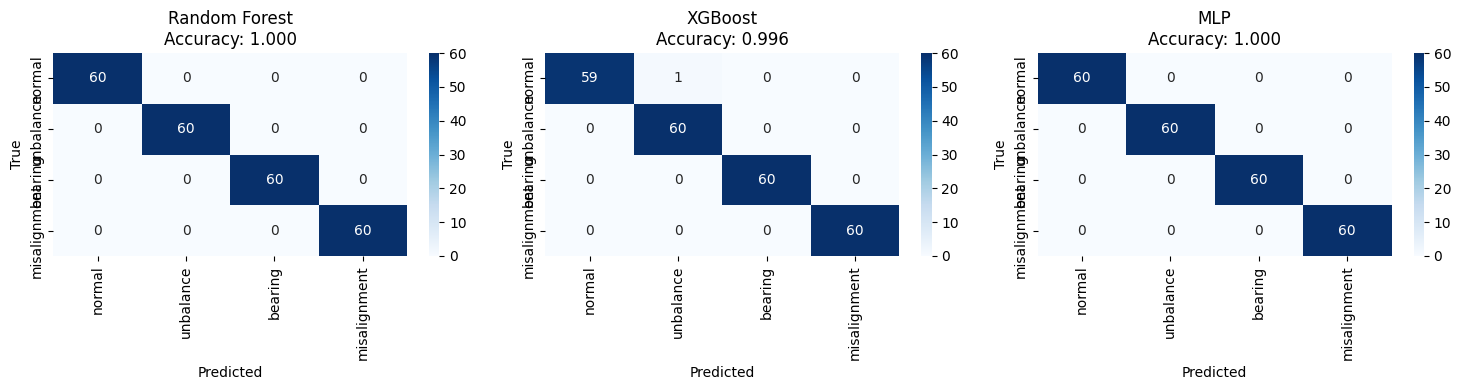

In [19]:
# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models_to_plot = [
    ('Random Forest', y_test, y_pred_rf),
    ('MLP', y_test, y_pred_mlp),
]

if xgb_model is not None:
    models_to_plot.insert(1, ('XGBoost', y_test, y_pred_xgb))

for ax, (name, y_true, y_pred) in zip(axes, models_to_plot):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=class_names, yticklabels=class_names)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{name}\nAccuracy: {accuracy_score(y_true, y_pred):.3f}')

plt.tight_layout()
plt.savefig('../models/trained/classification_confusion_matrices.png', dpi=150)
plt.show()

In [20]:
# Zusammenfassung
print("=" * 60)
print("MODELLVERGLEICH - Fehlerklassifikation")
print("=" * 60)

from sklearn.metrics import precision_score, recall_score, f1_score

results = [
    {
        'Modell': 'Random Forest',
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'Precision': precision_score(y_test, y_pred_rf, average='macro'),
        'Recall': recall_score(y_test, y_pred_rf, average='macro'),
        'F1-Score': f1_score(y_test, y_pred_rf, average='macro')
    },
    {
        'Modell': 'MLP',
        'Accuracy': accuracy_score(y_test, y_pred_mlp),
        'Precision': precision_score(y_test, y_pred_mlp, average='macro'),
        'Recall': recall_score(y_test, y_pred_mlp, average='macro'),
        'F1-Score': f1_score(y_test, y_pred_mlp, average='macro')
    }
]

if xgb_model is not None:
    results.insert(1, {
        'Modell': 'XGBoost',
        'Accuracy': accuracy_score(y_test, y_pred_xgb),
        'Precision': precision_score(y_test, y_pred_xgb, average='macro'),
        'Recall': recall_score(y_test, y_pred_xgb, average='macro'),
        'F1-Score': f1_score(y_test, y_pred_xgb, average='macro')
    })

if HAS_RAW_DATA:
    results.append({
        'Modell': '1D-CNN',
        'Accuracy': accuracy_score(y_raw_test, y_pred_cnn),
        'Precision': precision_score(y_raw_test, y_pred_cnn, average='macro'),
        'Recall': recall_score(y_raw_test, y_pred_cnn, average='macro'),
        'F1-Score': f1_score(y_raw_test, y_pred_cnn, average='macro')
    })

df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

MODELLVERGLEICH - Fehlerklassifikation
       Modell  Accuracy  Precision   Recall  F1-Score
Random Forest  1.000000   1.000000 1.000000  1.000000
      XGBoost  0.995833   0.995902 0.995833  0.995833
          MLP  1.000000   1.000000 1.000000  1.000000
       1D-CNN  0.250000   0.062500 0.250000  0.100000


## 8. Modelle speichern

In [21]:
import joblib
import json

MODEL_DIR = '../models/trained'

# Scaler
joblib.dump(scaler, f'{MODEL_DIR}/classification_scaler.joblib')
print("✓ Scaler gespeichert")

# Random Forest
joblib.dump(rf_model, f'{MODEL_DIR}/random_forest_classifier.joblib')
print("✓ Random Forest gespeichert")

# XGBoost
if xgb_model is not None:
    joblib.dump(xgb_model, f'{MODEL_DIR}/xgboost_classifier.joblib')
    print("✓ XGBoost gespeichert")

# MLP
mlp_model.save(f'{MODEL_DIR}/mlp_classifier.keras')
print("✓ MLP gespeichert")

# 1D-CNN
if HAS_RAW_DATA:
    cnn_model.save(f'{MODEL_DIR}/cnn_classifier.keras')
    print("✓ 1D-CNN gespeichert")

# Metadata
metadata = {
    'feature_names': feature_cols,
    'n_features': len(feature_cols),
    'class_names': class_names,
    'n_classes': n_classes,
    'scaler_mean': scaler.mean_.tolist(),
    'scaler_scale': scaler.scale_.tolist()
}

with open(f'{MODEL_DIR}/classification_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print("✓ Metadata gespeichert")

✓ Scaler gespeichert
✓ Random Forest gespeichert
✓ XGBoost gespeichert
✓ MLP gespeichert
✓ 1D-CNN gespeichert
✓ Metadata gespeichert


In [22]:
# ONNX Export für Random Forest
try:
    from skl2onnx import convert_sklearn
    from skl2onnx.common.data_types import FloatTensorType
    
    initial_type = [('input', FloatTensorType([None, len(feature_cols)]))]
    onnx_rf = convert_sklearn(rf_model, initial_types=initial_type)
    
    with open(f'{MODEL_DIR}/random_forest_classifier.onnx', 'wb') as f:
        f.write(onnx_rf.SerializeToString())
    
    print("✓ Random Forest als ONNX exportiert")
except ImportError:
    print("⚠ skl2onnx nicht installiert")

⚠ skl2onnx nicht installiert


In [23]:
# TensorFlow.js Export
try:
    import tensorflowjs as tfjs
    
    tfjs.converters.save_keras_model(mlp_model, f'{MODEL_DIR}/mlp_classifier_tfjs')
    print("✓ MLP als TensorFlow.js exportiert")
    
    if HAS_RAW_DATA:
        tfjs.converters.save_keras_model(cnn_model, f'{MODEL_DIR}/cnn_classifier_tfjs')
        print("✓ 1D-CNN als TensorFlow.js exportiert")
except ImportError:
    print("⚠ tensorflowjs nicht installiert")

failed to lookup keras version from the file,
    this is likely a weight only file
✓ MLP als TensorFlow.js exportiert
failed to lookup keras version from the file,
    this is likely a weight only file
✓ 1D-CNN als TensorFlow.js exportiert


## 9. Beispiel: Inference

In [24]:
def classify_fault(features_dict, model_type='random_forest'):
    """
    Klassifiziert einen Maschinenzustand.
    
    Returns:
    --------
    dict mit class_id, class_name, probabilities
    """
    # Features extrahieren
    X = np.array([[features_dict.get(f, 0) for f in feature_cols]])
    X_scaled = scaler.transform(X)
    
    if model_type == 'random_forest':
        class_id = rf_model.predict(X_scaled)[0]
        probabilities = rf_model.predict_proba(X_scaled)[0]
    elif model_type == 'mlp':
        probs = mlp_model.predict(X_scaled, verbose=0)[0]
        class_id = np.argmax(probs)
        probabilities = probs
    else:
        raise ValueError(f"Unknown model: {model_type}")
    
    return {
        'class_id': int(class_id),
        'class_name': class_names[class_id],
        'confidence': float(probabilities[class_id]),
        'probabilities': {name: float(p) for name, p in zip(class_names, probabilities)}
    }

# Test
test_sample = dict(zip(feature_cols, X_test[0]))
actual_class = class_names[y_test[0]]

print(f"Tatsächliche Klasse: {actual_class}\n")

for model in ['random_forest', 'mlp']:
    result = classify_fault(test_sample, model)
    print(f"{model}: {result['class_name']} (Confidence: {result['confidence']:.2%})")

Tatsächliche Klasse: normal

random_forest: normal (Confidence: 100.00%)
mlp: normal (Confidence: 100.00%)


## Zusammenfassung

### Trainierte Klassifikationsmodelle

| Modell | Datei | Input | Beschreibung |
|--------|-------|-------|-------------|
| Random Forest | `random_forest_classifier.joblib/.onnx` | Features | Robust, interpretierbar |
| XGBoost | `xgboost_classifier.joblib` | Features | Hohe Genauigkeit |
| MLP | `mlp_classifier.keras/tfjs` | Features | Deep Learning |
| 1D-CNN | `cnn_classifier.keras/tfjs` | Rohe Zeitreihen | End-to-End |

### Nächste Schritte

- **05_model_export.ipynb** - Detaillierter Export für Node-RED